<a href="https://colab.research.google.com/github/iamyoungjin/AI/blob/main/DeeplabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:37<00:00, 50.2MB/s]


In [ ]:
!unzip -q instance-level-human-parsing.zip

In [ ]:
!ls

'ICCV15_fashion_dataset(ATR)'   instance-level-human-parsing.zip
 instance-level_human_parsing   sample_data


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

In [ ]:
train_images = sorted(glob(os.path.join(DATA_DIR,'Images/*')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR,'Category_ids/*')))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(DATA_DIR,'Images/*')))[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES+NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR,'Category_ids/*')))[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES+NUM_TRAIN_IMAGES]

In [ ]:
def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image,channels=1) #gray scale
    image.set_shape([None,None,1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE,IMAGE_SIZE])
  else:
    image = tf.image.decode_png(image,channels=3) #RGB
    image.set_shape([None,None,3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE,IMAGE_SIZE])
    image = image/127.5 -1 #225/2 를 -1~1로 노말라이제이션
  
  return image

In [ ]:
def load_data(image_list,mask_list):
  image = read_image(image_list)
  mask = read_image(mask_list,mask=True)
  return image,mask
  

In [ ]:
def data_generator(image_list,mask_list):
  dataset = tf.data.Dataset.from_tensor_slices((image_list,mask_list))
  dataset = dataset.map(load_data, num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  return dataset

In [ ]:
train_dataset = data_generator(train_images,train_masks)
val_dataset = data_generator(val_images,val_masks)

print("Train Dataset: ",train_dataset)

print("Val Dataset: ",val_dataset)

Train Dataset:  <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset:  <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [ ]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding='same', use_bias=False):
  x = layers.Conv2D(num_filters, kernel_size=kernel_size, 
                    dilation_rate=dilation_rate, padding='same', 
                    use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
  x = layers.BatchNormalization()(x)
  return tf.nn.relu(x)

In [ ]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3],dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3]//x.shape[1], dims[-2] // x.shape[2]),
                                         interpolation='bilinear')(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool,out_1,out_6,out_12,out_18])
    output = convolution_block(x,kernel_size=1)
    return output

In [ ]:
def DeeplabV3(image_size,num_classes):
  model_input = keras.Input(shape=(image_size, image_size, 3))
  resnet50 = keras.applications.ResNet50(weights='imagenet',include_top=False, input_tensor=model_input)

  x = resnet50.get_layer('conv4_block6_2_relu').output
  x = DilatedSpatialPyramidPooling(x)

  input_a = layers.UpSampling2D(size=(image_size//4//x.shape[1],
                                      image_size//4//x.shape[2]),
                                interpolation = 'bilinear')(x)
  input_b = resnet50.get_layer('conv2_block3_2_relu').output
  input_b = convolution_block(input_b,num_filters=48,kernel_size=1)

  x = layers.Concatenate(axis=-1)([input_a,input_b])
  x = convolution_block(x)
  x = convolution_block(x)
  x = layers.UpSampling2D(size=(image_size//x.shape[1],
                                image_size//x.shape[2]),
                          interpolation='bilinear')(x)

  model_output = layers.Conv2D(num_classes,kernel_size=(1,1), padding='same')(x)
  return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3(image_size=IMAGE_SIZE,num_classes=NUM_CLASSES)
model.summary()



94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=loss,metrics=['accuracy'])
history = model.fit(train_dataset,validation_data=val_dataset, epochs=10)

Epoch 1/10
250/250 [==============================] - 254s 984ms/step - loss: 1.1912 - accuracy: 0.6429 - val_loss: 2.2922 - val_accuracy: 0.5960
Epoch 2/10
250/250 [==============================] - 243s 971ms/step - loss: 0.8447 - accuracy: 0.7304 - val_loss: 1.3597 - val_accuracy: 0.6056
Epoch 4/10
250/250 [==============================] - 244s 975ms/step - loss: 0.7780 - accuracy: 0.7511 - val_loss: 0.8967 - val_accuracy: 0.7075
Epoch 5/10
250/250 [==============================] - 242s 968ms/step - loss: 0.7394 - accuracy: 0.7618 - val_loss: 0.9327 - val_accuracy: 0.7056
Epoch 6/10
250/250 [==============================] - 241s 964ms/step - loss: 0.6530 - accuracy: 0.7905 - val_loss: 0.9854 - val_accuracy: 0.7081
Epoch 7/10
250/250 [==============================] - 242s 969ms/step - loss: 0.5960 - accuracy: 0.8094 - val_loss: 0.9190 - val_accuracy: 0.7093
Epoch 8/10
250/250 [==============================] - 241s 964ms/step - loss: 0.5661 - accuracy: 0.8189 - val_loss: 0.9930 -

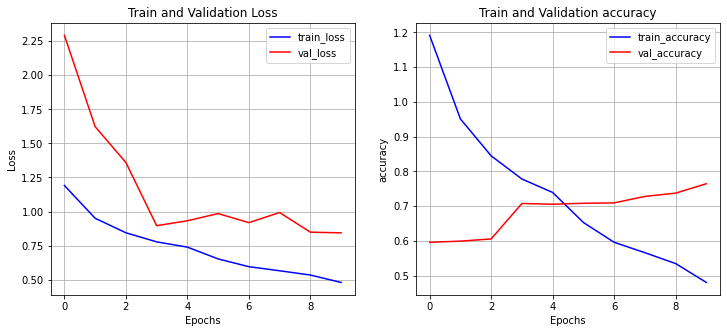

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(loss, color='blue', label='train_loss')
ax1.plot(val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

ax2 = fig.add_subplot(1,2,2)
ax2.plot(loss, color='blue', label='train_accuracy')
ax2.plot(val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [ ]:
colormap = loadmat("./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat")['colormap']
colormap = colormap * 100 
colormap = colormap.astype(np.uint8)

In [ ]:
def infer(model,image_tensor):
  predictions = model.predict(np.expand_dims(image_tensor),axis=0)
  predictions = np.squeeze(predictions)
  predictions = np.argmax(predictions, axis=2)
  return predictions

In [ ]:
def decode_segmentation_masks(mask, colormap, n_classes):
  r = np.zeros_like(mask).astype(np.uint8)
  g = np.zeros_like(mask).astype(np.uint8)
  b = np.zeros_like(mask).astype(np.uint8)
  for i in range(0, n_classes):
    idx = mask == i 
    r[idx] = colormap[i,0]
    g[idx] = colormap[i,1]
    b[idx] = colormap[i,2]

  rgb = np.stack([r,g,b],axis=2)
  return rgb

In [ ]:
def get_overlay(image,colored_mask):
  image = tf.keras.preprocessing.image.array_to_image(image)
  image = np.array(image).astype(np.uint8)
  overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
  return overlay

In [ ]:
def plot_samples_matplotlib(display_list, figsize=(5,3)):
  _, axes = plt.subplot(nrows=1,ncols=len(display_list),figsize=figsize)
  for i in range(len(display_list)):
    if display_list[i].shape[-1] == 3:
      axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    else:
      axes[i].imshow(display_list[i])
  plt.show()

In [ ]:
def plot_predictions(image_list,colormap,model):
  for image_file in image_list:
    image_tensor = read_image(image_file)
    prediction_mask = infer(image_tensor=image_tensor, model = model)
    prediction_colormap = decode_segmentation_mask(prediction_mask,colormap,20)
    overlay = get_overlay(image_tensor,prediction_colormap)
    plot_samples_matplotlib([image_tensor,overlay,prediction_colormap],figsize=(18,14))


In [ ]:
plot_predictions(train_images[:4],colormap,model=model)

TypeError: ignored

In [ ]:
plot_predictions(val_images[:4],colormap,model=model)